In [3]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:90%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

- iris 데이터 종 예측

In [2]:
import seaborn as sns # iris 데이터
import pandas as pd # 원핫인코딩
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [15]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# 독립변수와 종속변수 분리
iris_X = iris.iloc[:, :-1].to_numpy()
iris_y = iris.iloc[:, -1]
iris_Y = pd.get_dummies(iris_y).values
# iris_Y[::50]
# 훈련셋 : 테스트셋 = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y,
                                                   test_size=0.2,
                                                   stratify=iris_Y, # 층화추출
                                                   random_state=4) 
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

In [19]:
# 층화 추출했는지 확인 
pd.Series(np.argmax(Y_train, axis=1)).value_counts()

0    40
1    40
2    40
dtype: int64

In [20]:
pd.Series(np.argmax(Y_test, axis=1)).value_counts()

1    10
2    10
0    10
dtype: int64

In [22]:
# 2. 모델 구성 (입력4 - 출력3)
model = Sequential()
model.add(Dense(units=60, input_dim=4, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=3, activation='softmax'))

In [56]:
# 2. 모델 구성 (입력4 - 출력3)
model = Sequential([
    Input(4,),
    Dense(units=64, activation='relu'),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=16, activation='relu'),
    Dropout(0.1),
    Dense(units=3, activation='softmax'),
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 64)                320       
                                                                 
 dense_22 (Dense)            (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 32)                4128      
                                                                 
 dense_24 (Dense)            (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_25 (Dense)            (None, 3)                

In [57]:
# 3. 모델학습과정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [72]:
# 4. 학습 : epoch마다 val_accuracy(val_loss, accuracy, loss)값이 좋을 때 모델을 자동 저장 콜백 추가
          # 모델을 저장할 경로 : ./model/iris-100-val0.6521.h5
import os
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder) # model_save_folder가 없으면 폴더 생성
# 조기 종료 콜백     
earlystopping = EarlyStopping(patience=50) # monitor='val_loss' 기본값
# 모델 자동 저장 콜백
file = model_save_folder + 'iris-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath= file, # 저장경로
                        monitor = 'val_loss', # 모니터링할 지표 
                        save_best_only=True, # 지표가 개성된 경우만 저장. False면 매번 저장
                        mode = 'auto', # 값이 클수록 저장. 'min'은 값이 작을수록 저장. auto도 있음
                        verbose = 1) # 저장 여부 로그 출력 (0:출력안함)
hist = model.fit(X_train, Y_train,
                # batch_size=50, # 한 배치사이즈마다 w, b 조정
                epochs=500,
                validation_split=0.2,
                callbacks=[checkpoint, earlystopping]
                )

Epoch 1/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0219 - accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.04006, saving model to ./model\iris-001-val1.0000.h5
3/3 [==============================] - 0s 41ms/step - loss: 0.0381 - accuracy: 0.9896 - val_loss: 0.0401 - val_accuracy: 1.0000
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0136 - accuracy: 1.0000
Epoch 2: val_loss improved from 0.04006 to 0.02618, saving model to ./model\iris-002-val1.0000.h5
3/3 [==============================] - 0s 25ms/step - loss: 0.0405 - accuracy: 0.9896 - val_loss: 0.0262 - val_accuracy: 1.0000
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0087 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.02618 to 0.01384, saving model to ./model\iris-003-val1.0000.h5
3/3 [==============================] - 0s 25ms/step - loss: 0.0396 - accuracy: 0.9896 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 4/500
1/3 [=========>....................

3/3 [==============================] - 0s 16ms/step - loss: 0.0313 - accuracy: 0.9896 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 61/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0758 - accuracy: 0.9688
Epoch 61: val_loss did not improve from 0.00858
3/3 [==============================] - 0s 17ms/step - loss: 0.0302 - accuracy: 0.9896 - val_loss: 0.0156 - val_accuracy: 1.0000
Epoch 62/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0691 - accuracy: 0.9688
Epoch 62: val_loss did not improve from 0.00858
3/3 [==============================] - 0s 12ms/step - loss: 0.0437 - accuracy: 0.9792 - val_loss: 0.0087 - val_accuracy: 1.0000


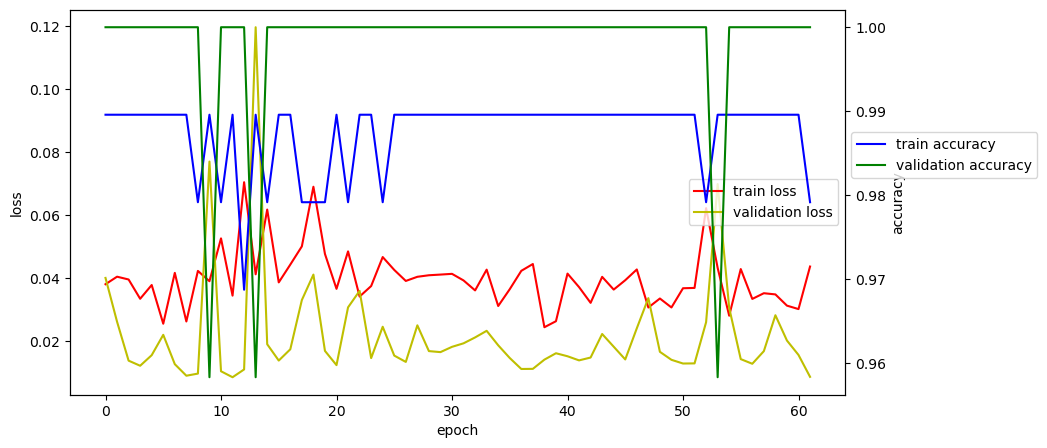

In [74]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [75]:
# 모델 평가
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 35ms/step - loss: 0.1729 - accuracy: 0.9333


[0.17289979755878448, 0.9333333373069763]

In [76]:
# 교차표
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model.predict(X_test), axis=1)
ctab = pd.crosstab(real, pred)
ctab.columns = iris['species'][::50] #['setosa', 'versicolor', 'virginica']
ctab.columns.name = 'predict'
ctab.index = iris['species'][::50] 
ctab.index.name = 'real'
ctab

1/1 [==============================] - 0s 32ms/step


predict,setosa,versicolor,virginica
real,,,
setosa,10,0,0
versicolor,0,8,2
virginica,0,0,10


In [44]:
list(iris['species'][::50])

['setosa', 'versicolor', 'virginica']

In [78]:
# 저장된 모델 중 성능이 제일 좋아 보이는 것 load
from tensorflow.keras.models import load_model
model2 = load_model('model/iris-141-val1.0000.h5')
model2.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 125ms/step - loss: 0.2137 - accuracy: 0.9333


[0.21374207735061646, 0.9333333373069763]

In [79]:
# 저장된 모델의 교차표
real = np.argmax(Y_test, axis=1)
pred = np.argmax(model2.predict(X_test), axis=1)
ctab = pd.crosstab(real, pred)
ctab.columns = iris['species'][::50] #['setosa', 'versicolor', 'virginica']
ctab.columns.name = 'predict'
ctab.index = iris['species'][::50] 
ctab.index.name = 'real'
ctab

1/1 [==============================] - 0s 51ms/step


predict,setosa,versicolor,virginica
real,,,
setosa,10,0,0
versicolor,0,8,2
virginica,0,0,10


In [85]:
# 모델 사용하기(예측하기)
iris[100:101]

,sepal_length,sepal_width,petal_length,petal_width,species
100,6.3,3.3,6.0,2.5,virginica


In [86]:
model.predict(np.array([[6.3, 3.4, 6.1, 2.5]]))

1/1 [==============================] - 0s 18ms/step


array([[8.3991182e-11, 1.9221265e-04, 9.9980778e-01]], dtype=float32)